In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
#data processing
imgProcessor = T.Compose(
                        [T.Resize((16,16)),
                         T.ToTensor(),
                         T.Normalize(
                                 mean = [0.5],
                                 std = [0.5]) #change the img range from [0,1] to [-1,1]
                        ])

In [3]:
#data loading
dataPath = r"E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\"
mnistTrain = datasets.MNIST(dataPath,train=True,download=True,transform=imgProcessor)
mmnistTest = datasets.MNIST(dataPath,train=False,download=True,transform=imgProcessor)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\MNIST\raw\train-images-idx3-ubyte.gz to E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\MNIST\raw\train-labels-idx1-ubyte.gz to E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\MNIST\raw\t10k-images-idx3-ubyte.gz to E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\MNIST\raw\t10k-labels-idx1-ubyte.gz to E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\MNIST\raw



In [5]:
 #data example
image,label = mnistTrain[0]
print(type(image)) #tensor
print(image)
print(type(label)) #int
print(label)

<class 'torch.Tensor'>
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -0.9843, -0.9608, -0.8353, -0.7882, -0.8039, -0.6314, -0.8196,
          -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -0.9922, -0.8353, -0.5686, -0.2471,
           0.0667,  0.2235,  0.4745,  0.3255,  0.2392,  0.5294, -0.3961,
          -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -0.9765, -0.2392,  0.7098,  0.8588,
           0.9137,  0.7569,  0.8588, -0.0824, -0.4980, -0.6000, -0.8980,
          -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -0.6863, -0.0824,  0.5529,
           0.5216, -0.5294, -

In [7]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [23]:
##Network (include weight initialization)
class LeNet1989(nn.Module):
    def __init__(self):
        super(LeNet1989,self).__init__()
        
        self.conv1 = nn.Conv2d(1,12,5,stride = 2, padding = 2)
        self.act1 = nn.Tanh()

        self.conv2 = nn.Conv2d(12,12,5,stride = 2, padding = 2)
        self.act2 = nn.Tanh()

        self.fc1 = nn.Linear(192,30)
        self.act3 = nn.Tanh()
        
        self.fc2 = nn.Linear(30,10)
        self.act4 = nn.Tanh()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                F_in = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data = torch.rand(m.weight.data.size()) * 4.8 / F_in - 2.4 / F_in
            if isinstance(m, nn.Linear):
                F_in = m.out_features
                m.weight.data = torch.rand(m.weight.data.size()) * 4.8 / F_in - 2.4 / F_in
                
    def forward(self,x):
        x = self.conv1(x)
        x = 1.7195 * self.act1(2.0*x/3.0)
        x = self.conv2(x)
        x = 1.7195 * self.act2(2.0*x/3.0)

        x = x.view(-1,192)

        x = self.fc1(x)
        x = 1.7195 * self.act3(2.0*x/3.0)
        x = self.fc2(x)
        out = 1.7195 * self.act4(2.0*x/3.0)

        return out

In [46]:
#train
losslist = []
error = []

def train(model, epochs, optimizer, loss_fn, trainset, testset):
    trainnum = len(trainset)
    testnum = len(testset)
    for epoch in range(epochs):
        print("epoch:{:02d} / {:d}".format(epoch+1,epochs))
        losses = 0
        for i, (img, label) in enumerate(trainset):
            x = img.unsqueeze(0).to(device)
            
            y = torch.zeros(1, 10)
            y[0][label] = 1.0
            y = y.to(device)
            
            out = model(x)
            optimizer.zero_grad()
            loss = loss_fn(out,y)
            loss.backward()
            optimizer.step()
            losses += loss.item()
            
            losslist.append(losses/trainnum)
        
        with torch.no_grad():
            errornum = 0
            for img, label in testset:
                x = img.unsqueeze(0).to(device)
                out = model(x)
                _, pred_y = out.max(dim = 1)
                if pred_y != label:
                    errornum += 1
                error.append(errornum/testnum)
        if epoch %8 == 0:
            torch.save(model.state_dict(),r"E:\\github\\CNN-models-reproduction\\LeNet\\epoch-{:d}_loss-{:.6f}_error-{:.2%}.pth".format(epoch,losslist[-1],error[-1]))

epoch:01 / 40
epoch:02 / 40
epoch:03 / 40
epoch:04 / 40
epoch:05 / 40
epoch:06 / 40
epoch:07 / 40
epoch:08 / 40
epoch:09 / 40
epoch:10 / 40
epoch:11 / 40
epoch:12 / 40
epoch:13 / 40
epoch:14 / 40
epoch:15 / 40
epoch:16 / 40
epoch:17 / 40
epoch:18 / 40
epoch:19 / 40
epoch:20 / 40
epoch:21 / 40
epoch:22 / 40
epoch:23 / 40
epoch:24 / 40
epoch:25 / 40
epoch:26 / 40
epoch:27 / 40
epoch:28 / 40
epoch:29 / 40
epoch:30 / 40
epoch:31 / 40
epoch:32 / 40
epoch:33 / 40
epoch:34 / 40
epoch:35 / 40
epoch:36 / 40
epoch:37 / 40
epoch:38 / 40
epoch:39 / 40
epoch:40 / 40


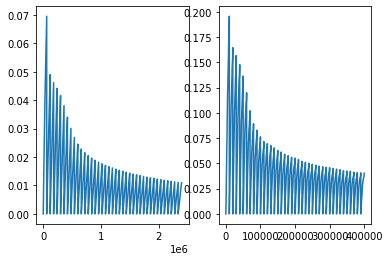

In [47]:
if __name__ == '__main__':
    model = LeNet1989().to(device)
    loss = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr = 1e-3)
    epochs = 40
    train(model, epochs, optimizer, loss, mnistTrain, mmnistTest)
    plt.subplot(1,2,1)
    plt.plot(losslist)
    plt.subplot(1,2,2)
    plt.plot(error)
    plt.show()